In [ ]:
"""
Example workflow demonstrating how to use the improved GraphBuilder
for planar graph classification with 11-16 nodes
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, DataLoader

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, softmax
from torch_scatter import scatter_add

import numpy as np
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

import pandas as pd
import ast

In [2]:
from GNN_architectures import create_gnn_model #  architecture: One of ['gin', 'gat', 'hybrid', 'planar', 'simple']
from GraphBuilder_with_features import GraphBuilder, create_graph_dataset

In [3]:
def train_and_evaluate(dataset, model, num_epochs=100, k_folds=5):
    """Train and evaluate model using k-fold cross validation with learning rate scheduling"""
    
    # Prepare for k-fold cross validation
    labels = [data.y.item() for data in dataset]
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_feature_importance = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(range(len(dataset)), labels)):
        print(f"\nFold {fold + 1}/{k_folds}")
        
        # Split dataset
        train_dataset = [dataset[i] for i in train_idx]
        test_dataset = [dataset[i] for i in test_idx]
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        
        # Initialize optimizer with a higher initial learning rate
        # The scheduler will handle the reduction
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
        
        # Learning rate scheduler
        # ReduceLROnPlateau: Reduces LR when validation loss plateaus
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #    optimizer, 
        #    mode='min',  # Minimize loss
        #    factor=0.5,  # Reduce LR by half
        #    patience=10,  # Wait 10 epochs before reducing
        #    min_lr=1e-5,  # Minimum LR
        #)
        
        # Alternative schedulers you could use:
        # 1. CosineAnnealingLR - smooth cosine decay
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        #     optimizer, T_max=num_epochs, eta_min=1e-5
        # )
        
        # 2. StepLR - step decay at fixed intervals
        # scheduler = torch.optim.lr_scheduler.StepLR(
        #     optimizer, step_size=30, gamma=0.5
        # )
        
        # 3. OneCycleLR - one cycle policy (very effective for small datasets)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=0.1, epochs=num_epochs, 
            steps_per_epoch=len(train_loader)
        )
        
        # Training
        best_val_loss = float('inf')
        patience_counter = 0
        early_stop_patience = 20
        
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = F.cross_entropy(out, batch.y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            # Validation phase
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                # Use train dataset as validation since we have limited data
                for batch in train_loader:
                    out = model(batch.x, batch.edge_index, batch.batch)
                    val_loss += F.cross_entropy(out, batch.y)
                    pred = out.argmax(dim=1)
                    correct += pred.eq(batch.y).sum().item()
                    total += batch.y.size(0)
            
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(train_loader)
            val_acc = correct / total
            
            # Update learning rate based on validation loss
            scheduler.step(avg_val_loss)
            
            # For OneCycleLR, call scheduler.step() after each batch instead
            if isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                scheduler.step()
            
            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    print(f"  Early stopping at epoch {epoch + 1}")
                    break
            
            if (epoch + 1) % 20 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
                      f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")
        
        # Final evaluation on test set
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                out = model(batch.x, batch.edge_index, batch.batch)
                pred = out.argmax(dim=1)
                correct += pred.eq(batch.y).sum().item()
                total += batch.y.size(0)
        
        accuracy = correct / total
        fold_accuracies.append(accuracy)
        print(f"  Test Accuracy: {accuracy:.4f}")
        
        # Feature importance for this fold
        if hasattr(dataset[0], 'feature_names'):
            importance = evaluate_feature_importance(model, test_dataset, 
                                                   dataset[0].feature_names)
            fold_feature_importance.append(importance)
    
    # Summary
    print(f"\n{'='*50}")
    print(f"Cross-validation Results:")
    print(f"  Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
    print(f"  All Folds: {fold_accuracies}")
    
    # Average feature importance across folds
    if fold_feature_importance:
        avg_importance = {}
        for feat_name in dataset[0].feature_names:
            scores = [dict(fold)[feat_name] for fold in fold_feature_importance]
            avg_importance[feat_name] = np.mean(scores)
        
        print(f"\nTop 10 Most Important Features:")
        sorted_importance = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
        for i, (feat, score) in enumerate(sorted_importance[:10]):
            print(f"  {i+1}. {feat:25s}: {score:.4f}")
    
    return fold_accuracies, avg_importance



In [4]:

def evaluate_feature_importance(model, dataset, feature_names):
    """Evaluate which features are most important for the model"""
    
    model.eval()
    feature_gradients = []
    
    with torch.enable_grad():
        for data in dataset:
            data.x.requires_grad = True
            
            # Forward pass
            out = model(data.x, data.edge_index)
            loss = F.nll_loss(out, data.y.unsqueeze(0))
            
            # Backward pass
            loss.backward()
            
            # Store gradients
            grad = data.x.grad.abs().mean(dim=0)
            feature_gradients.append(grad.numpy())
    
    # Average gradients across all graphs
    avg_gradients = np.mean(feature_gradients, axis=0)
    
    # Sort features by importance
    importance_scores = list(zip(feature_names, avg_gradients))
    importance_scores.sort(key=lambda x: x[1], reverse=True)
    
    return importance_scores

In [5]:
def compare_feature_sets(graphs_data, model_name = 'gin'):
    """Compare different feature configurations"""
    
    feature_configs = {
        'Minimal': {
            'selected_features': ['basic', 'face'],
            'laplacian_pe_k': 0
        },
        'Planar-focused': {
            'selected_features': ['basic', 'face', 'dual'],
            'laplacian_pe_k': 2
        },
        'Balanced': {
            'selected_features': ['basic', 'face', 'spectral_node', 'centrality'],
            'laplacian_pe_k': 3
        },
        'Full': {
            'selected_features': ['basic', 'face', 'spectral_node', 'dual', 'centrality'],
            'laplacian_pe_k': 4
        }
    }
    
    results = {}
    
    for config_name, config in feature_configs.items():
        print(f"\n{'='*60}")
        print(f"Testing configuration: {config_name}")
        print(f"{'='*60}")
        
        # Create dataset with this configuration
        dataset, scaler = create_graph_dataset(graphs_data, config)

        # Initialize model
        model = create_gnn_model(model_name, num_features = dataset[0].x.shape[1], hidden_dim=64, num_layers=3)
        
        # Train and evaluate
        accuracies, importance = train_and_evaluate(dataset = dataset, model = model, num_epochs=70, k_folds=4)
        
        results[config_name] = {
            'accuracies': accuracies,
            'mean_accuracy': np.mean(accuracies),
            'std_accuracy': np.std(accuracies),
            'num_features': dataset[0].x.shape[1],
            'importance': importance
        }
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    
    configs = list(results.keys())
    means = [results[c]['mean_accuracy'] for c in configs]
    stds = [results[c]['std_accuracy'] for c in configs]
    num_features = [results[c]['num_features'] for c in configs]
    
    x = np.arange(len(configs))
    
    plt.subplot(1, 2, 1)
    plt.bar(x, means, yerr=stds, capsize=10)
    plt.xlabel('Configuration')
    plt.ylabel('Accuracy')
    plt.title('Model Performance by Feature Configuration')
    plt.xticks(x, configs, rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.scatter(num_features, means, s=100)
    plt.errorbar(num_features, means, yerr=stds, fmt='none', capsize=5)
    for i, config in enumerate(configs):
        plt.annotate(config, (num_features[i], means[i]), 
                    xytext=(5, 5), textcoords='offset points')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Feature Dimensionality')
    
    plt.tight_layout()
    plt.show()
    
    return results

In [6]:
loop=8
# Create the edge and y lists from the csv files\
edges=[]
y=[]
for i in range(loop,loop+1):
    filename = f'../Graph_Edge_Data/den_graph_data_{loop}.csv'
    df = pd.read_csv(filename)
    edges += df['EDGES'].tolist()
    y += df['COEFFICIENTS'].tolist()
edges = [ast.literal_eval(e) for e in edges]    
graphs_data = list(zip(edges, y))


Testing configuration: Minimal
Extracting features...
Normalizing features...
Created dataset with 1432 graphs
Feature dimensions: 5
Feature names: ['degree', 'num_faces', 'avg_face_size', 'max_face_size', 'face_size_variance']

Fold 1/4


/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.5891, Val Loss: 1.5861, Val Acc: 0.7225, LR: 0.004001
  Epoch 40/70, Train Loss: 0.5249, Val Loss: 1.5166, Val Acc: 0.7300, LR: 0.004001
  Epoch 60/70, Train Loss: 0.5366, Val Loss: 1.5171, Val Acc: 0.7598, LR: 0.004001
  Test Accuracy: 0.7374

Fold 2/4
  Epoch 20/70, Train Loss: 0.4623, Val Loss: 1.4281, Val Acc: 0.7942, LR: 0.004001
  Early stopping at epoch 37
  Test Accuracy: 0.7458

Fold 3/4
  Epoch 20/70, Train Loss: 0.3962, Val Loss: 1.3397, Val Acc: 0.8343, LR: 0.004001
  Epoch 40/70, Train Loss: 0.4088, Val Loss: 1.3104, Val Acc: 0.8417, LR: 0.004001
  Epoch 60/70, Train Loss: 0.4083, Val Loss: 1.3079, Val Acc: 0.8520, LR: 0.004001
  Test Accuracy: 0.7430

Fold 4/4
  Epoch 20/70, Train Loss: 0.3677, Val Loss: 1.2953, Val Acc: 0.8557, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3709, Val Loss: 1.3245, Val Acc: 0.8399, LR: 0.004001
  Epoch 60/70, Train Loss: 0.3690, Val Loss: 1.3024, Val Acc: 0.8613, LR: 0.004001
  Test Accuracy: 0.7486

Cross-validati

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.6319, Val Loss: 1.5876, Val Acc: 0.7030, LR: 0.004001
  Epoch 40/70, Train Loss: 0.5221, Val Loss: 1.5738, Val Acc: 0.6816, LR: 0.004001
  Epoch 60/70, Train Loss: 0.4673, Val Loss: 1.4232, Val Acc: 0.7942, LR: 0.004001
  Test Accuracy: 0.7682

Fold 2/4
  Epoch 20/70, Train Loss: 0.4418, Val Loss: 1.3930, Val Acc: 0.8110, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3650, Val Loss: 1.3416, Val Acc: 0.8184, LR: 0.004001
  Epoch 60/70, Train Loss: 0.3745, Val Loss: 1.2782, Val Acc: 0.8650, LR: 0.004001
  Test Accuracy: 0.7961

Fold 3/4
  Epoch 20/70, Train Loss: 0.3293, Val Loss: 1.2711, Val Acc: 0.8696, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3441, Val Loss: 1.2616, Val Acc: 0.8845, LR: 0.004001
  Epoch 60/70, Train Loss: 0.3445, Val Loss: 1.2885, Val Acc: 0.8790, LR: 0.004001
  Test Accuracy: 0.7514

Fold 4/4
  Epoch 20/70, Train Loss: 0.2865, Val Loss: 1.2279, Val Acc: 0.8948, LR: 0.004001
  Epoch 40/70, Train Loss: 0.2739, Val Loss: 1.1869, Val Acc: 0.9143

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.4347, Val Loss: 1.4263, Val Acc: 0.8110, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3235, Val Loss: 1.2895, Val Acc: 0.8669, LR: 0.004001
  Epoch 60/70, Train Loss: 0.2539, Val Loss: 1.3023, Val Acc: 0.8678, LR: 0.004001
  Test Accuracy: 0.7542

Fold 2/4
  Epoch 20/70, Train Loss: 0.2441, Val Loss: 1.1327, Val Acc: 0.9367, LR: 0.004001
  Epoch 40/70, Train Loss: 0.2294, Val Loss: 1.1654, Val Acc: 0.9264, LR: 0.004001
  Epoch 60/70, Train Loss: 0.1915, Val Loss: 1.0596, Val Acc: 0.9823, LR: 0.004001
  Test Accuracy: 0.8184

Fold 3/4
  Epoch 20/70, Train Loss: 0.1933, Val Loss: 1.0689, Val Acc: 0.9795, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1121, Val Loss: 1.0434, Val Acc: 0.9907, LR: 0.004001
  Early stopping at epoch 55
  Test Accuracy: 0.8743

Fold 4/4
  Epoch 20/70, Train Loss: 0.1759, Val Loss: 1.0768, Val Acc: 0.9851, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1297, Val Loss: 1.0268, Val Acc: 0.9953, LR: 0.004000
  Epoch 60/70, Train Loss: 0.0881, Val 

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.4366, Val Loss: 1.3651, Val Acc: 0.8175, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3414, Val Loss: 1.2812, Val Acc: 0.8631, LR: 0.004001
  Epoch 60/70, Train Loss: 0.2645, Val Loss: 1.1914, Val Acc: 0.9274, LR: 0.004001
  Test Accuracy: 0.8212

Fold 2/4
  Epoch 20/70, Train Loss: 0.2311, Val Loss: 1.1307, Val Acc: 0.9562, LR: 0.004001
  Epoch 40/70, Train Loss: 0.2101, Val Loss: 1.1361, Val Acc: 0.9562, LR: 0.004001
  Epoch 60/70, Train Loss: 0.1601, Val Loss: 1.0656, Val Acc: 0.9730, LR: 0.004001
  Test Accuracy: 0.8296

Fold 3/4
  Epoch 20/70, Train Loss: 0.1672, Val Loss: 1.1009, Val Acc: 0.9683, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1840, Val Loss: 1.0924, Val Acc: 0.9674, LR: 0.004001
  Epoch 60/70, Train Loss: 0.1610, Val Loss: 1.0689, Val Acc: 0.9851, LR: 0.004001
  Test Accuracy: 0.8939

Fold 4/4
  Epoch 20/70, Train Loss: 0.1179, Val Loss: 1.0479, Val Acc: 0.9860, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1011, Val Loss: 1.0402, Val Acc: 0.9870

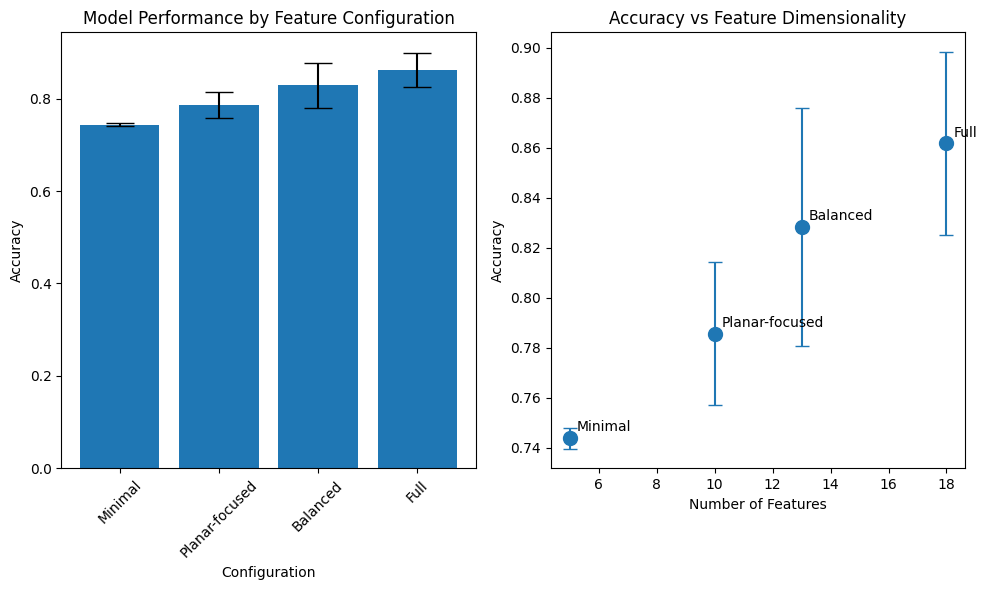

In [7]:
# Compare different feature configurations
results = compare_feature_sets(graphs_data)


Testing configuration: Minimal
Extracting features...
Normalizing features...
Created dataset with 1432 graphs
Feature dimensions: 5
Feature names: ['degree', 'num_faces', 'avg_face_size', 'max_face_size', 'face_size_variance']

Fold 1/4


/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.6356, Val Loss: 1.6067, Val Acc: 0.6760, LR: 0.004001
  Epoch 40/70, Train Loss: 0.5744, Val Loss: 1.5392, Val Acc: 0.7225, LR: 0.004001
  Epoch 60/70, Train Loss: 0.5423, Val Loss: 1.5301, Val Acc: 0.7207, LR: 0.004001
  Test Accuracy: 0.7458

Fold 2/4
  Epoch 20/70, Train Loss: 0.4622, Val Loss: 1.4323, Val Acc: 0.7663, LR: 0.004001
  Epoch 40/70, Train Loss: 0.4917, Val Loss: 1.4287, Val Acc: 0.7961, LR: 0.004001
  Epoch 60/70, Train Loss: 0.4617, Val Loss: 1.3894, Val Acc: 0.7877, LR: 0.004001
  Test Accuracy: 0.7514

Fold 3/4
  Epoch 20/70, Train Loss: 0.4247, Val Loss: 1.3911, Val Acc: 0.8017, LR: 0.004001
  Epoch 40/70, Train Loss: 0.4078, Val Loss: 1.3567, Val Acc: 0.8166, LR: 0.004001
  Epoch 60/70, Train Loss: 0.4487, Val Loss: 1.3713, Val Acc: 0.8389, LR: 0.004001
  Test Accuracy: 0.7123

Fold 4/4
  Epoch 20/70, Train Loss: 0.4138, Val Loss: 1.3984, Val Acc: 0.7933, LR: 0.004001
  Epoch 40/70, Train Loss: 0.4021, Val Loss: 1.3289, Val Acc: 0.8147

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.5381, Val Loss: 1.5053, Val Acc: 0.7588, LR: 0.004001
  Epoch 40/70, Train Loss: 0.4890, Val Loss: 1.3964, Val Acc: 0.8045, LR: 0.004001
  Epoch 60/70, Train Loss: 0.4019, Val Loss: 1.3524, Val Acc: 0.8231, LR: 0.004001
  Test Accuracy: 0.8045

Fold 2/4
  Epoch 20/70, Train Loss: 0.3918, Val Loss: 1.3113, Val Acc: 0.8538, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3809, Val Loss: 1.3221, Val Acc: 0.8296, LR: 0.004001
  Epoch 60/70, Train Loss: 0.3430, Val Loss: 1.3710, Val Acc: 0.8240, LR: 0.004001
  Test Accuracy: 0.8156

Fold 3/4
  Epoch 20/70, Train Loss: 0.3186, Val Loss: 1.2462, Val Acc: 0.8892, LR: 0.004001
  Epoch 40/70, Train Loss: 0.2813, Val Loss: 1.2085, Val Acc: 0.8957, LR: 0.004001
  Early stopping at epoch 46
  Test Accuracy: 0.8101

Fold 4/4
  Epoch 20/70, Train Loss: 0.3062, Val Loss: 1.2344, Val Acc: 0.8920, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3236, Val Loss: 1.3188, Val Acc: 0.8613, LR: 0.004001
  Early stopping at epoch 57
  Test Acc

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.5119, Val Loss: 1.3607, Val Acc: 0.8184, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3300, Val Loss: 1.2299, Val Acc: 0.8966, LR: 0.004001
  Epoch 60/70, Train Loss: 0.2739, Val Loss: 1.1954, Val Acc: 0.9190, LR: 0.004001
  Test Accuracy: 0.7849

Fold 2/4
  Epoch 20/70, Train Loss: 0.2147, Val Loss: 1.1287, Val Acc: 0.9600, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1925, Val Loss: 1.1048, Val Acc: 0.9637, LR: 0.004001
  Epoch 60/70, Train Loss: 0.1640, Val Loss: 1.0963, Val Acc: 0.9646, LR: 0.004001
  Test Accuracy: 0.8436

Fold 3/4
  Epoch 20/70, Train Loss: 0.1624, Val Loss: 1.0586, Val Acc: 0.9804, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1364, Val Loss: 1.0415, Val Acc: 0.9860, LR: 0.004001
  Epoch 60/70, Train Loss: 0.1350, Val Loss: 1.0681, Val Acc: 0.9786, LR: 0.004001
  Test Accuracy: 0.8883

Fold 4/4
  Epoch 20/70, Train Loss: 0.1354, Val Loss: 1.0573, Val Acc: 0.9832, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1018, Val Loss: 1.0327, Val Acc: 0.9888

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.4453, Val Loss: 1.3826, Val Acc: 0.8045, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3920, Val Loss: 1.3870, Val Acc: 0.8035, LR: 0.004001
  Epoch 60/70, Train Loss: 0.3083, Val Loss: 1.2299, Val Acc: 0.8864, LR: 0.004001
  Test Accuracy: 0.8212

Fold 2/4
  Epoch 20/70, Train Loss: 0.2563, Val Loss: 1.1704, Val Acc: 0.9330, LR: 0.004001
  Epoch 40/70, Train Loss: 0.2054, Val Loss: 1.1433, Val Acc: 0.9497, LR: 0.004001
  Epoch 60/70, Train Loss: 0.2180, Val Loss: 1.1591, Val Acc: 0.9432, LR: 0.004001
  Test Accuracy: 0.8212

Fold 3/4
  Epoch 20/70, Train Loss: 0.1806, Val Loss: 1.0774, Val Acc: 0.9683, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1695, Val Loss: 1.0703, Val Acc: 0.9823, LR: 0.004001
  Epoch 60/70, Train Loss: 0.1191, Val Loss: 1.0525, Val Acc: 0.9786, LR: 0.004001
  Test Accuracy: 0.8547

Fold 4/4
  Epoch 20/70, Train Loss: 0.1364, Val Loss: 1.0756, Val Acc: 0.9823, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1368, Val Loss: 1.0365, Val Acc: 0.9926

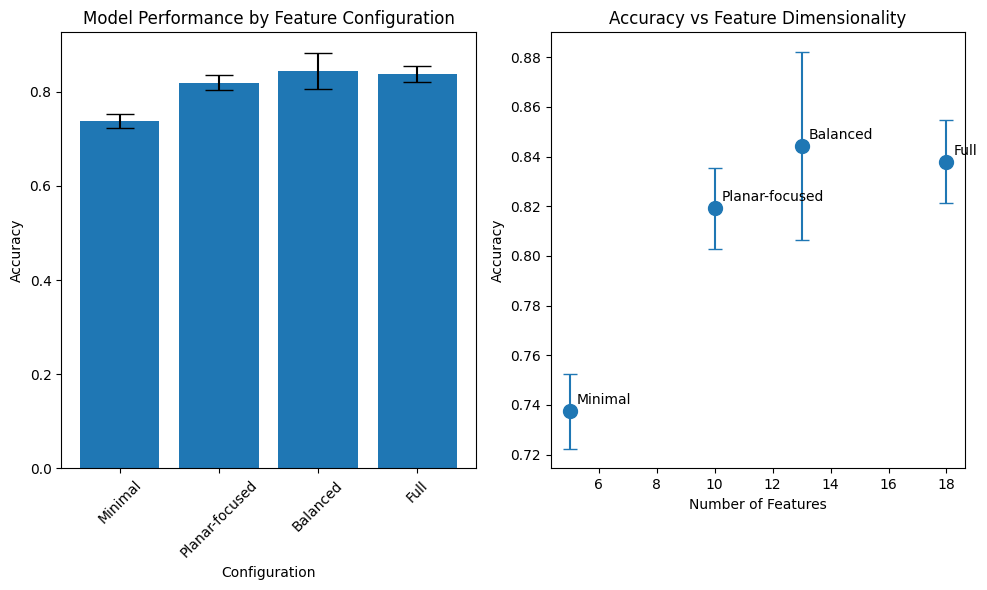

In [12]:
# Compare different feature configurations
results = compare_feature_sets(graphs_data)

In [13]:
# Print summary
print("\n" + "="*60)
print("SUMMARY: Feature Configuration Comparison")
print("="*60)

for config, res in results.items():
    print(f"\n{config}:")
    print(f"  Features: {res['num_features']}")
    print(f"  Accuracy: {res['mean_accuracy']:.4f} ± {res['std_accuracy']:.4f}")


SUMMARY: Feature Configuration Comparison

Minimal:
  Features: 5
  Accuracy: 0.7374 ± 0.0150

Planar-focused:
  Features: 10
  Accuracy: 0.8191 ± 0.0162

Balanced:
  Features: 13
  Accuracy: 0.8443 ± 0.0378

Full:
  Features: 18
  Accuracy: 0.8380 ± 0.0168



Testing configuration: Minimal
Extracting features...
Normalizing features...
Created dataset with 1432 graphs
Feature dimensions: 5
Feature names: ['degree', 'num_faces', 'avg_face_size', 'max_face_size', 'face_size_variance']

Fold 1/4


/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.4514, Val Loss: 1.4519, Val Acc: 0.7728, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3954, Val Loss: 1.3715, Val Acc: 0.8156, LR: 0.004001
  Early stopping at epoch 54
  Test Accuracy: 0.5391

Fold 2/4
  Epoch 20/70, Train Loss: 0.6932, Val Loss: 1.6931, Val Acc: 0.5093, LR: 0.004001
  Epoch 40/70, Train Loss: 0.6003, Val Loss: 1.5826, Val Acc: 0.6899, LR: 0.004001
  Epoch 60/70, Train Loss: 0.4989, Val Loss: 1.4734, Val Acc: 0.7719, LR: 0.004001
  Test Accuracy: 0.7263

Fold 3/4
  Epoch 20/70, Train Loss: 0.4378, Val Loss: 1.4053, Val Acc: 0.8175, LR: 0.004001
  Epoch 40/70, Train Loss: 0.4280, Val Loss: 1.3648, Val Acc: 0.8408, LR: 0.004001
  Early stopping at epoch 52
  Test Accuracy: 0.7067

Fold 4/4
  Epoch 20/70, Train Loss: 0.4156, Val Loss: 1.3691, Val Acc: 0.8315, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3470, Val Loss: 1.3459, Val Acc: 0.8464, LR: 0.004001
  Epoch 60/70, Train Loss: 0.4098, Val Loss: 1.5174, Val Acc: 0.7654, LR: 0.004001
  Test Acc

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.6609, Val Loss: 1.6397, Val Acc: 0.6257, LR: 0.004001
  Early stopping at epoch 37
  Test Accuracy: 0.7039

Fold 2/4
  Epoch 20/70, Train Loss: 0.4380, Val Loss: 1.4519, Val Acc: 0.7905, LR: 0.004001
  Epoch 40/70, Train Loss: 0.4081, Val Loss: 1.3651, Val Acc: 0.8445, LR: 0.004001
  Epoch 60/70, Train Loss: 0.3843, Val Loss: 1.4287, Val Acc: 0.8007, LR: 0.004001
  Test Accuracy: 0.7598

Fold 3/4
  Epoch 20/70, Train Loss: 0.4030, Val Loss: 1.3818, Val Acc: 0.8222, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3442, Val Loss: 1.2920, Val Acc: 0.8827, LR: 0.004001
  Epoch 60/70, Train Loss: 0.3093, Val Loss: 1.3113, Val Acc: 0.8678, LR: 0.004001
  Test Accuracy: 0.7933

Fold 4/4
  Epoch 20/70, Train Loss: 0.3294, Val Loss: 1.2824, Val Acc: 0.8827, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3044, Val Loss: 1.2945, Val Acc: 0.8743, LR: 0.004001
  Epoch 60/70, Train Loss: 0.2869, Val Loss: 1.2681, Val Acc: 0.8864, LR: 0.004001
  Test Accuracy: 0.8184

Cross-validati

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.6270, Val Loss: 1.6822, Val Acc: 0.5512, LR: 0.004001
  Early stopping at epoch 39
  Test Accuracy: 0.5112

Fold 2/4
  Epoch 20/70, Train Loss: 0.6935, Val Loss: 1.6930, Val Acc: 0.5093, LR: 0.004001
  Early stopping at epoch 36
  Test Accuracy: 0.5084

Fold 3/4
  Epoch 20/70, Train Loss: 0.6933, Val Loss: 1.6930, Val Acc: 0.5093, LR: 0.004001
  Epoch 40/70, Train Loss: 0.6931, Val Loss: 1.6930, Val Acc: 0.5093, LR: 0.004001
  Early stopping at epoch 48
  Test Accuracy: 0.5084

Fold 4/4
  Epoch 20/70, Train Loss: 0.6934, Val Loss: 1.6931, Val Acc: 0.5093, LR: 0.004001
  Early stopping at epoch 39
  Test Accuracy: 0.5084

Cross-validation Results:
  Mean Accuracy: 0.5091 ± 0.0012
  All Folds: [0.5111731843575419, 0.5083798882681564, 0.5083798882681564, 0.5083798882681564]

Top 10 Most Important Features:
  1. betweenness_centrality   : 0.0000
  2. pagerank                 : 0.0000
  3. eigenvector_centrality   : 0.0000
  4. clustering_coefficient   : 0.0000


/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Epoch 20/70, Train Loss: 0.2910, Val Loss: 1.2661, Val Acc: 0.8799, LR: 0.004001
  Epoch 40/70, Train Loss: 0.4629, Val Loss: 1.4038, Val Acc: 0.8222, LR: 0.004001
  Early stopping at epoch 43
  Test Accuracy: 0.8017

Fold 2/4
  Epoch 20/70, Train Loss: 0.3237, Val Loss: 1.2756, Val Acc: 0.8873, LR: 0.004001
  Epoch 40/70, Train Loss: 0.3412, Val Loss: 1.2836, Val Acc: 0.8911, LR: 0.004001
  Epoch 60/70, Train Loss: 0.2396, Val Loss: 1.2168, Val Acc: 0.9134, LR: 0.004001
  Test Accuracy: 0.8352

Fold 3/4
  Epoch 20/70, Train Loss: 0.1568, Val Loss: 1.1427, Val Acc: 0.9423, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1265, Val Loss: 1.1100, Val Acc: 0.9646, LR: 0.004001
  Epoch 60/70, Train Loss: 0.0926, Val Loss: 1.0526, Val Acc: 0.9870, LR: 0.004001
  Test Accuracy: 0.8268

Fold 4/4
  Epoch 20/70, Train Loss: 0.1043, Val Loss: 1.1181, Val Acc: 0.9637, LR: 0.004001
  Epoch 40/70, Train Loss: 0.1130, Val Loss: 1.0826, Val Acc: 0.9749, LR: 0.004001
  Epoch 60/70, Train Loss: 0.1543, Val 

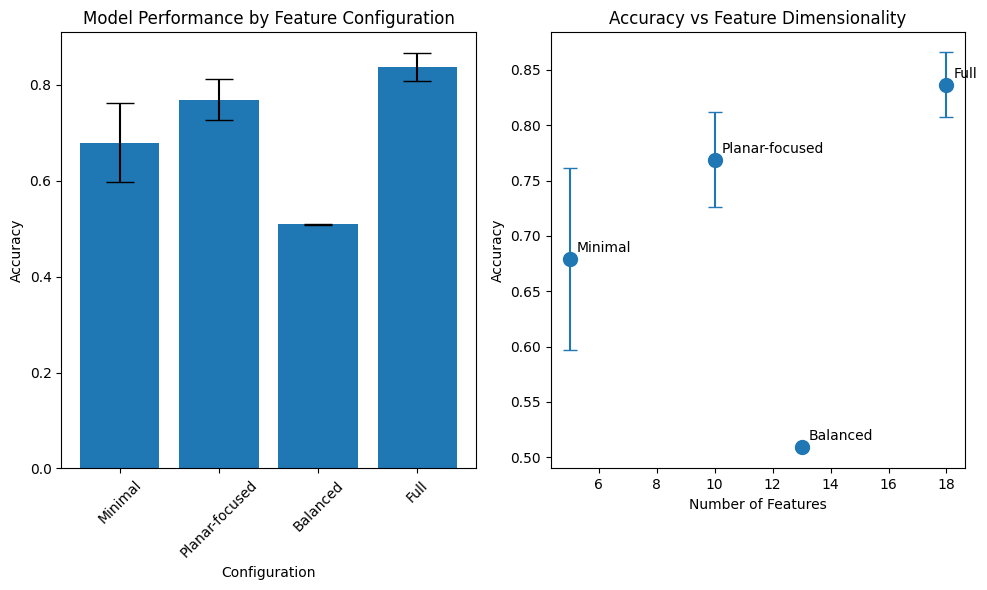

In [16]:
# Compare different feature configurations
results = compare_feature_sets(graphs_data, model_name='hybrid')